# Build a multimodal image retrieval system using KNN search and CLIP embeddings

In this notebook, we are going to walk through how to create a multimodal image retrieval system.

We will use Elasticsearch's KNN search features to build and manage a vector index, and CLIP embeddings calculated with the open source Roboflow Inference server.

By the end of this guide, we will be able to run semantic search queries using text and images with Elasticsearch.

** Note: We recommend running this notebook with a GPU so that CLIP can run faster. Check to make sure you are connected to a GPU in Colab before running the notebook. **

Let's begin!

## Step #1: Install dependencies and connect to Elasticsearch instance

To get started, we need to install the Elasticsearch SDK and Roboflow Inference, two dependencies we will use in this guide:

In [1]:
!pip install elasticsearch "inference[clip]" roboflow -q

Next, we can connect to our Elasticsearch instance:

In [2]:
from elasticsearch import Elasticsearch
from getpass import getpass

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#creating-an-api-key
ELASTIC_API_KEY = getpass("Elastic Api Key: ")

# Update the Elasticsearch URL based on your own setup
client = Elasticsearch(
    "https://my-elasticsearch-project-b00d1d.es.us-east-1.aws.elastic.cloud:443",
    api_key=ELASTIC_API_KEY,
)

Elastic Api Key: ··········


## Step #2: Create index

Next, we need to create an index that supports k-nearest neighbor search. This type of search lets us find the closest vectors to an input vector.

The way a search query works is:

1. We compute an input vector for a query like "coffee" or a photo.
2. We send the input vector to Elasticsearch to find the k-nearest neighbors.

We can create our search index with the following schema:

In [3]:
client.indices.create(
    index="knn",
    body={
        "mappings": {
            "properties": {
                "vector": {
                    "type": "dense_vector",
                    "dims": 512,
                    "similarity": "cosine",
                },
                "filename": {
                    "type": "keyword",
                },
            },
        },
    },
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'knn'})

The default index type used with KNN search is L2 Norm, also known as Euclidean distance. This distance metric doesn't work well for CLIP similarity. Thus, above we explicitly say we want to create a cosine similarity index. CLIP embeddings are best compared with cosine similarity.

For this guide, we will use a CLIP model with 512 dimensions. If you use a different CLIP model, make sure that you set the dims value to the number of dimensions of the vector returned by the CLIP model.

## Step #3: Download dataset

For this guide, we are going to use a sample of 128 images from the larger Microsoft COCO dataset. This dataset contains a wide range of objects, ideal for testing the capabilities of our semantic search engine.

We are going to download the dataset from Roboflow Universe, the largest community of open source computer vision datasets on the web.

Run the following code to download the dataset:

In [3]:
from roboflow import Roboflow

rf = Roboflow(api_key=getpass("ROBOFLOW_API_KEY"))
project = rf.workspace("team-roboflow").project("coco-128")
version = project.version(2)
dataset = version.download("yolov8")

ROBOFLOW_API_KEY··········
loading Roboflow workspace...
loading Roboflow project...


You will be prompted to specify your Roboflow API key when you run the code above.

[Learn how to retrieve your Roboflow API key](https://docs.roboflow.com/api-reference/authentication)

## Step #4: Calculate and save CLIP embeddings

With our dataset downloaded, we can now calculate CLIP embeddings for all images. These embeddings can be used to find images that are semantically similar to an input query. An input query can be an embedding of a text string or an image.

We can calculate our CLIP embeddings and save them in Elasticsearch with this code:

In [4]:
from inference.models import Clip
import os
from tqdm import tqdm

IMAGE_DIRECTORY = "./COCO-128-2/train/images"

# See a full list of supported models at
# https://inference.roboflow.com/foundation/clip/#how-can-i-use-clip-model-in-inference
clip = Clip(model_id="clip/ViT-B-16")

# create index if it doesn't exist for KNN with two fields: vector and file name
for file in tqdm(os.listdir(IMAGE_DIRECTORY)):
    if not file.endswith(".jpg"):
        continue

    image_path = os.path.join(IMAGE_DIRECTORY, file)
    vector = clip.embed_image(image_path)

    client.index(
        index="demo",
        body={
            "vector": vector.tolist()[0],
            "filename": file,
        },
    )

Creating inference sessions


CLIP model loaded in 5.30 seconds


100%|██████████| 128/128 [00:50<00:00,  2.56it/s]


When the code first runs, the CLIP weights will be downloaded and cached in the notebook. The weights will then be loaded into memory. This may take 10-30 seconds.

Then, embeddings for all images in your dataset will be calculated. The amount of time this will take will depend on how many images are in your dataset.

## Step #4: Run a search query

With our index set up, we can now run a search query.

We can run a search query with either an embedding of a text query or an embedding of an image.

To use a text as an input, you can use this code to retrieve an input vector for use in running a search:

In [5]:
query_vector = clip.embed_text("coffee")

To use an image as an input, you can use this code:

In [ ]:
query_vector = clip.embed_image("path/to/image")

We can then pass our query vector into an Elasticsearch search:

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7956582E07D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7956584E7950>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7956584E6250>]


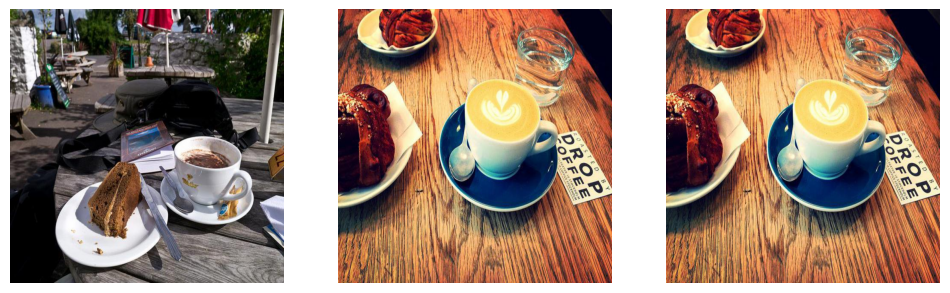

In [24]:
import supervision as sv
from PIL import Image

response = client.search(
    index="demo",
    body={
        "query": {
            "knn": {
                "field": "vector",
                "query_vector": query_vector.tolist()[0],  # The input vector
                "k": 3,
            }
        }
    },
)

images = [
    Image.open(os.path.join(IMAGE_DIRECTORY, i["_source"]["filename"]))
    for i in response["hits"]["hits"][:3]
]

sv.plot_images_grid(images, grid_size=(1, 3))

The k value above indicates how many of the nearest vectors should be retrieved from each shard. The size parameter of a query determines how many results to return. Since we are working with one shard for this demo, the query will return three results.

## Conclusion

We have successfully run a semantic search and found images similar to our input query!

With Elasticsearch and the CLIP features in Roboflow Inference, you can create a multimodal search engine. You can use the search engine for image retrieval, image comparison and deduplication, multimodal Retrieval Augmented Generation with visual prompts, and more.

To learn more about using Roboflow Inference, refer to the [Roboflow Inference documentation](https://inference.roboflow.com). To find data for your next computer vision project, check out [Roboflow Universe](https://universe.roboflow.com).